In [1]:
import sys
import os

# # Go up two levels to reach the project root and add it to the path
sys.path.append(os.path.abspath("../"))

In [2]:
from src.loader.load_dataset_with_raw_signals import load_all_matfiles
df = load_all_matfiles(channels=['vibration_1'])

df.head()

Processing ../dataset/paderborn-db: 0it [00:00, ?it/s]
Processing ../dataset/paderborn-db/KA08:  56%|█████▋    | 45/80 [00:01<00:00, 45.26it/s]

Error loading ../dataset/paderborn-db/KA08/N15_M01_F10_KA08_2.mat: Expecting matrix here


Processing ../dataset/paderborn-db/KI04: 100%|██████████| 80/80 [00:01<00:00, 44.59it/s]

Skipped 1 files.


,bearing_id,torque_nm,speed_rpm,radial_force_n,label,vibration_1
0,KA01,0.7,1500,400,1,"[-0.2166748045443072, -0.16784667957657598, -0..."
1,KA01,0.7,900,1000,1,"[0.19226074206044158, -0.122070312419328, -0.4..."
2,KA01,0.7,1500,400,1,"[0.1770019530080256, -0.0244140624838656, -0.1..."
3,KA01,0.7,1500,400,1,"[-0.07629394526208, -0.0213623046733824, -0.14..."
4,KA01,0.7,1500,1000,1,"[0.4028320309837824, 0.39672851536281595, 0.40..."


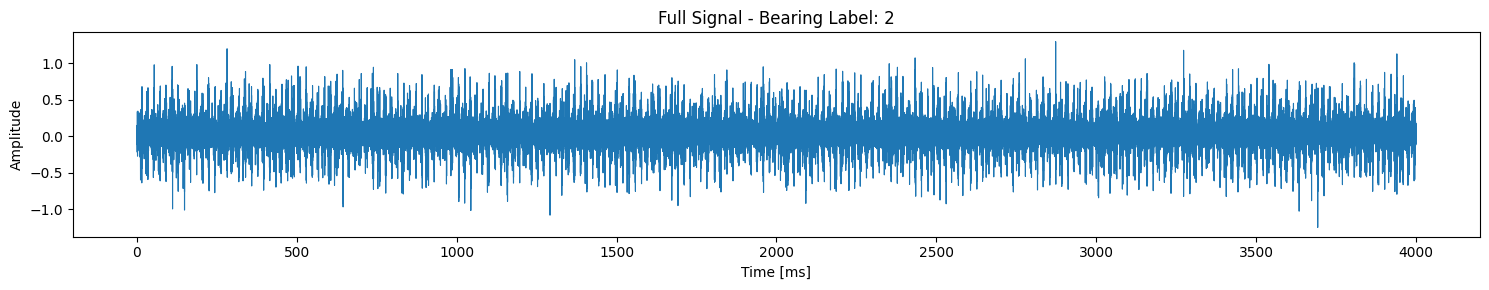

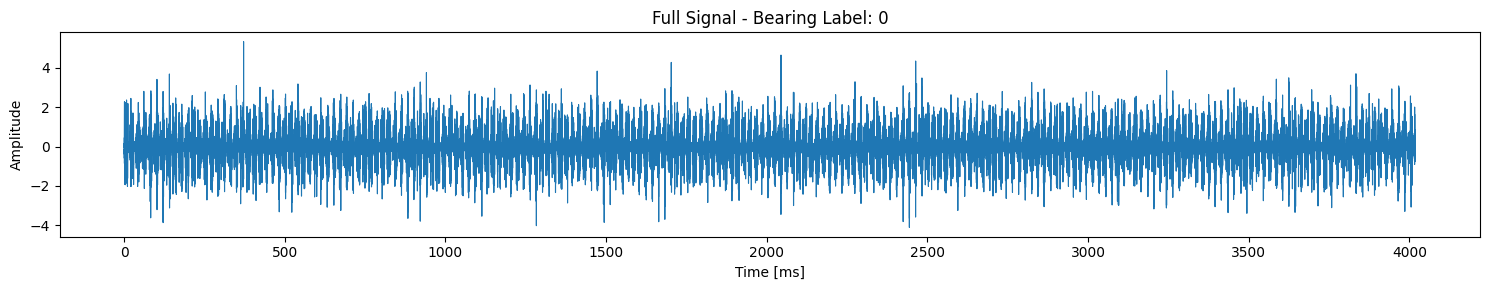

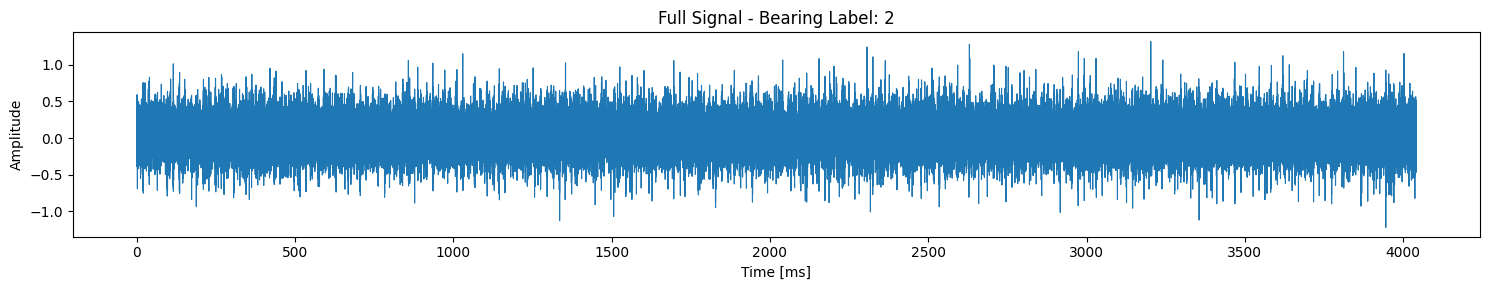

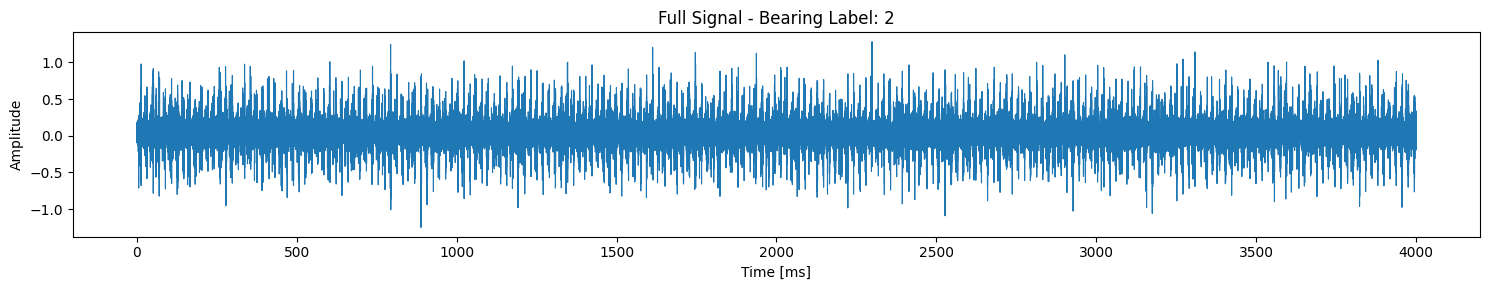

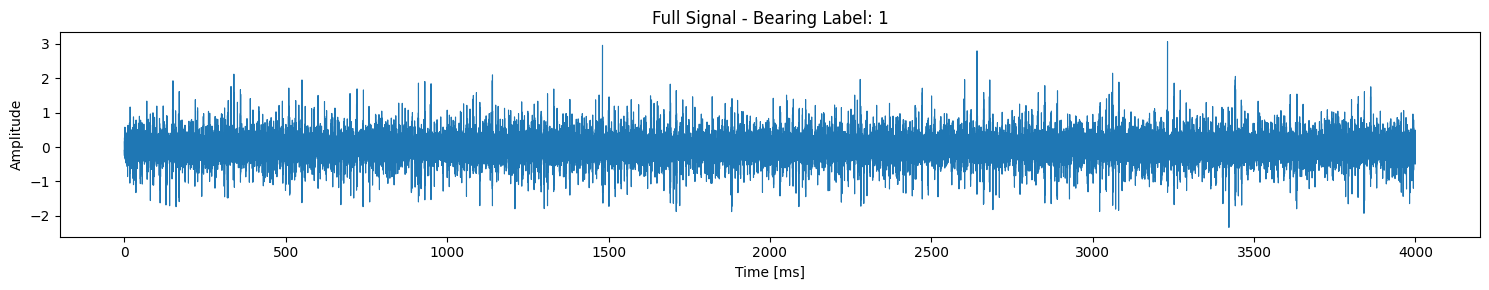

In [3]:
# Visualize a few signals with time domain plots
import random
import matplotlib.pyplot as plt
import numpy as np

# Sampling frequency for Paderborn dataset
fs = 64000  # 64 kHz

# Pick 5 random rows
random_rows = random.sample(range(len(df)), 5)

for row in random_rows:
    signal = df.iloc[row]['vibration_1']  # vibration column
    label = df.iloc[row]['label']         # bearing condition/fault label

    # Time axis in milliseconds
    time_ms = np.arange(len(signal)) / fs * 1000

    # Plot full signal
    plt.figure(figsize=(15, 3))
    plt.plot(time_ms, signal, linewidth=0.8)
    plt.xlabel('Time [ms]')
    plt.ylabel('Amplitude')
    plt.title(f'Full Signal - Bearing Label: {label}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
# Df class distribution
df['label'].value_counts()

label
1    959
2    880
0    480
3    240
Name: count, dtype: int64

In [6]:
# balance dataset
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df[['vibration_1']], df['label'])
df = pd.concat([X_resampled, y_resampled], axis=1)

df['label'].value_counts()

label
0    240
1    240
2    240
3    240
Name: count, dtype: int64

In [7]:
# Split df to train and test
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['label'])
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (768, 2)
Test shape: (192, 2)


In [8]:
# Signal Data Information
fs = 64000
new_sample_length = 0.25  # 0.5  seconds
window_size = int(new_sample_length * fs)
window_stride = window_size // 2  # 50% overlap
downsampling_factor = 4
# split signals to segments

def split_signal(signal, window_size, window_stride):
    segments = []
    num_segments = (len(signal) - window_size) // window_stride + 1
    for i in range(num_segments):
        start = i * window_stride
        end = start + window_size
        segment = signal[start:end]
        # float32
        segment = segment.astype(np.float16)
        # downsampling
        segment = segment[::downsampling_factor]
         # normalize signal
        segment = (segment - np.mean(segment)) / (np.std(segment) + 1e-8)
        segments.append(segment)
    return segments

def create_new_segments(df):
    X_segments = []
    y_labels = []
    idx_segments = []
    for index, row in df.iterrows():
        signal = row['vibration_1']
        segments = split_signal(signal, window_size, window_stride)
        X_segments.extend(segments)
        y_labels.extend([row['label']] * len(segments))
        idx_segments.extend([index] * len(segments))
    return X_segments, y_labels, idx_segments

# Create new segments

X_train, y_train, idx_train = create_new_segments(df_train)
X_test, y_test, idx_test = create_new_segments(df_test)

print("X_train shape:", len(X_train))
print("y_train shape:", len(y_train))
print("X_test shape:", len(X_test))
print("y_test shape:", len(y_test))

X_train shape: 23831
y_train shape: 23831
X_test shape: 5950
y_test shape: 5950


In [9]:
# get value counts for y_train
import pandas as pd

y_train_counts = pd.Series(y_train).value_counts()
y_train_counts

3    5959
1    5959
2    5958
0    5955
Name: count, dtype: int64

In [10]:
# get value counts for y_test
import pandas as pd

y_test_counts = pd.Series(y_test).value_counts()
y_test_counts

0    1492
3    1487
1    1487
2    1484
Name: count, dtype: int64

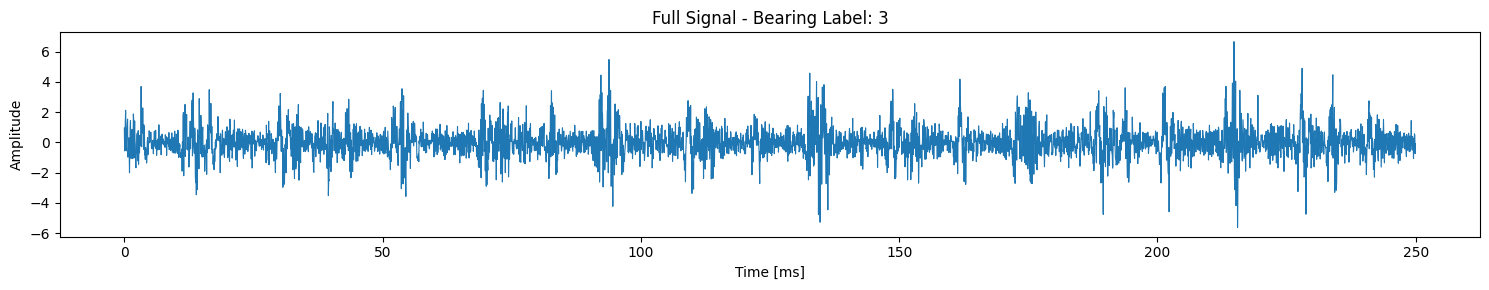

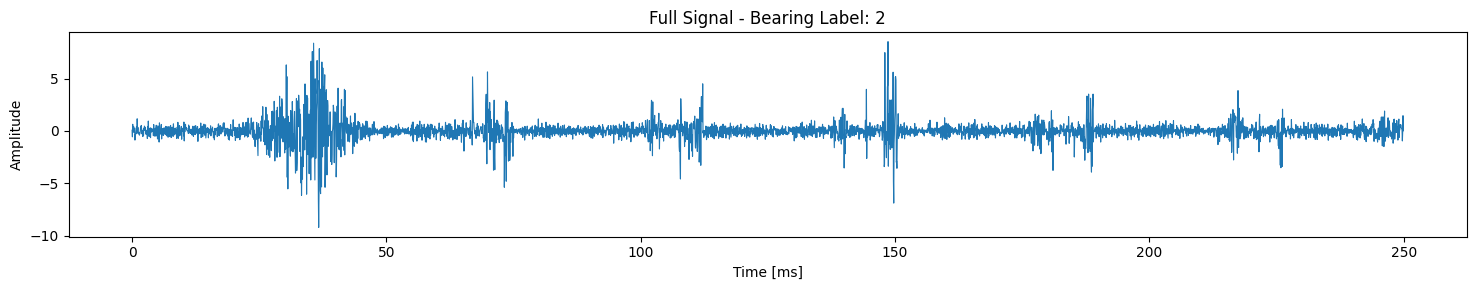

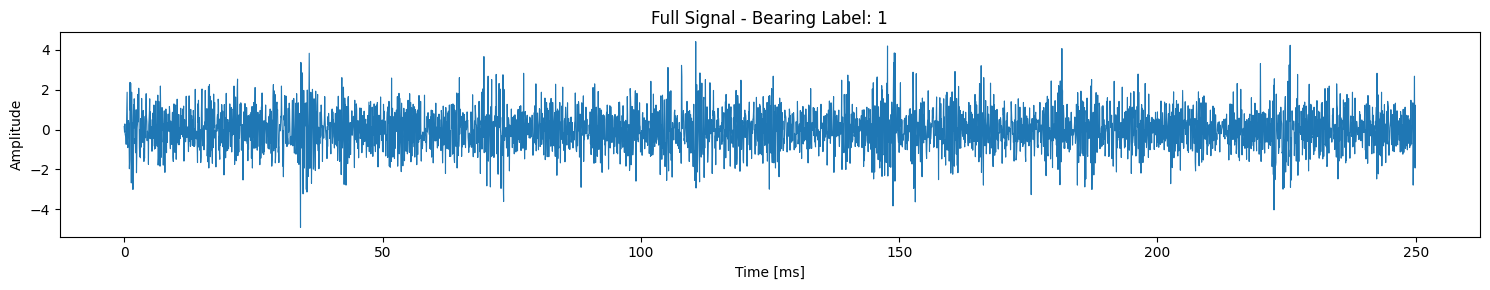

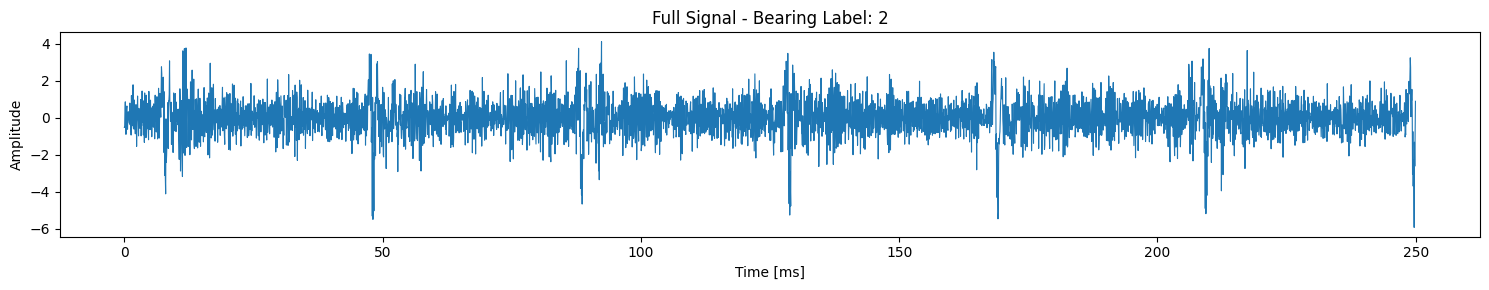

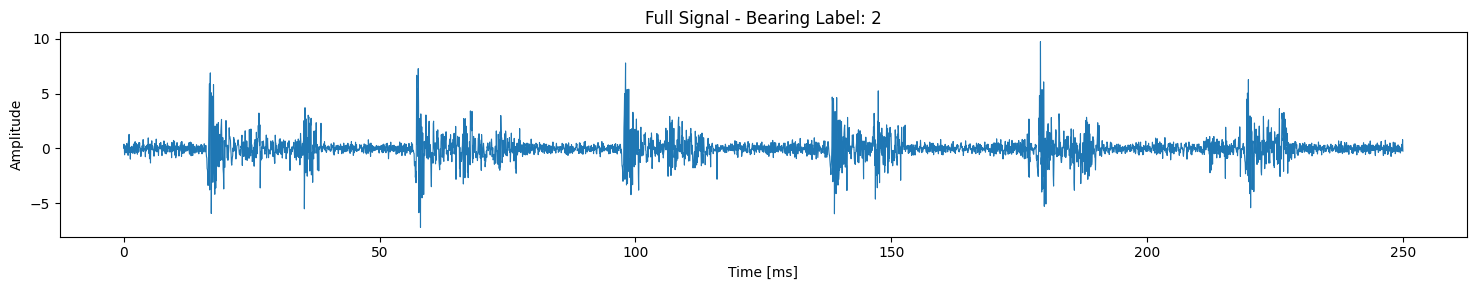

In [11]:
# Visualize a few signals with time domain plots
import random
import matplotlib.pyplot as plt
import numpy as np

# Pick 5 random rows from X_train_resampled and y_train_resampled
random_rows = random.sample(range(len(X_train)), 5)

for row in random_rows:
    signal = X_train[row]
    label = y_train[row]

    # Time axis in milliseconds
    time_ms = np.arange(len(signal)) / (fs / downsampling_factor) * 1000

    # Plot full signal
    plt.figure(figsize=(15, 3))
    plt.plot(time_ms, signal, linewidth=0.8)
    plt.xlabel('Time [ms]')
    plt.ylabel('Amplitude')
    plt.title(f'Full Signal - Bearing Label: {label}')
    plt.tight_layout()
    plt.show()
    plt.close()

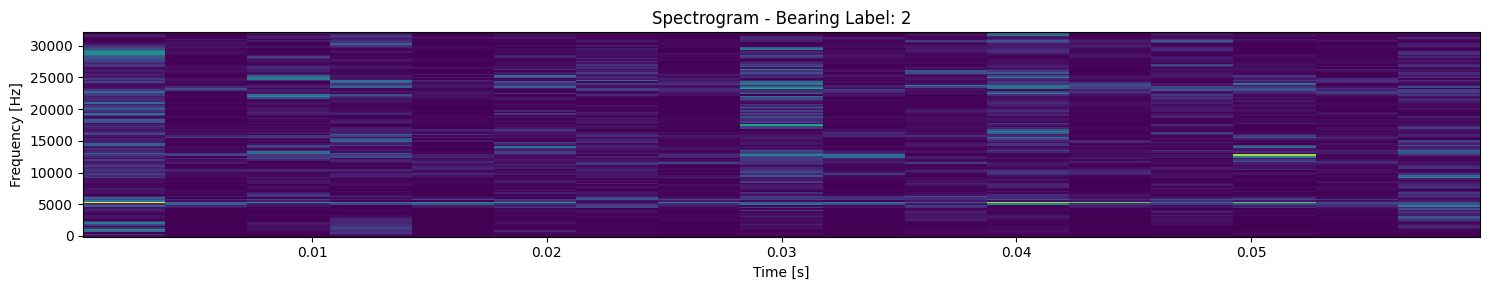

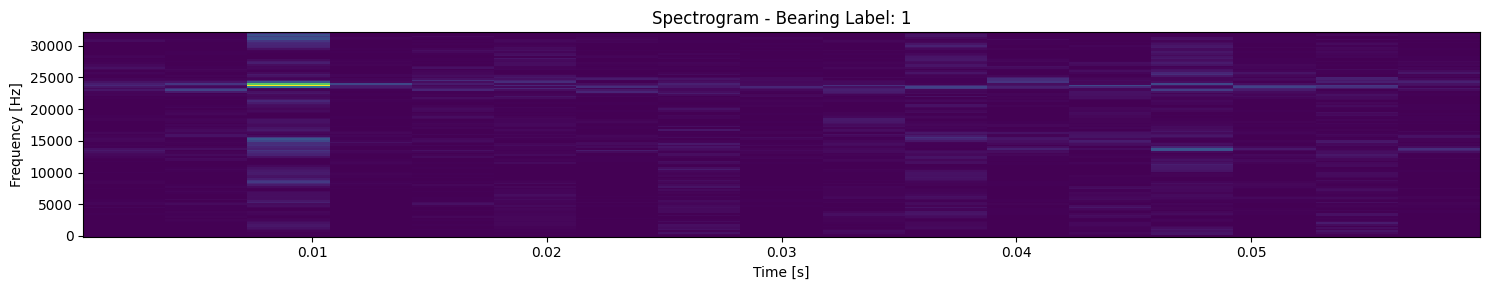

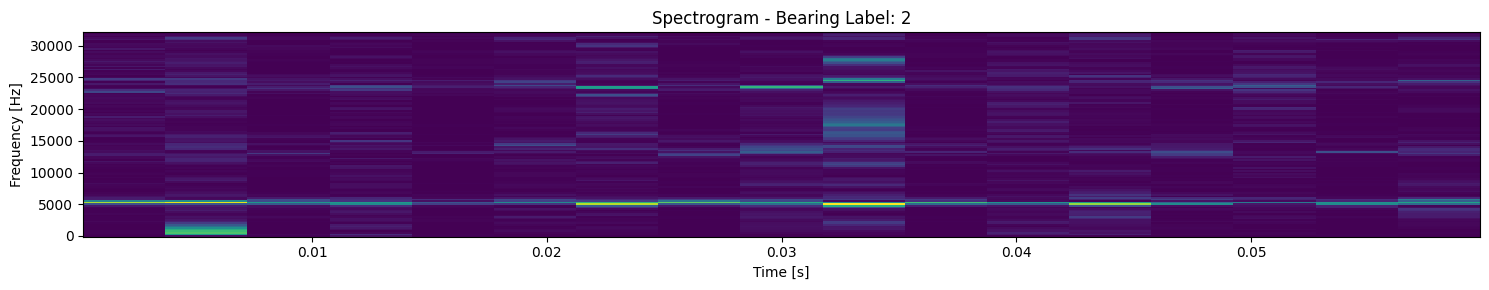

In [12]:
import scipy

def get_spectrogram(signal):
    f, t, Sxx = scipy.signal.spectrogram(np.array(signal), fs, window='hamming')
    return f, t, Sxx

random_rows = random.sample(range(len(X_train)), 3)

for row in random_rows:
    signal = X_train[row]
    label = y_train[row]

    f, t, Sxx = get_spectrogram(signal)

    plt.figure(figsize=(15, 3))
    plt.pcolormesh(t, f, Sxx)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.title(f'Spectrogram - Bearing Label: {label}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
import os
import cv2
import numpy as np

output_dir = '../exports/spectrogram_images/train'
os.makedirs(output_dir, exist_ok=True)

folder_names = {
    0: 'healthy',
    1: 'inner_race',
    2: 'outer_race',
    3: 'other_fault'
}

# Create class folders
for class_name in folder_names.values():
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

for i, (signal, y_label) in enumerate(zip(X_train, y_train)):

    f, t, Sxx = get_spectrogram(signal)

    # ---- Log scale (important)
    Sxx = 10 * np.log10(Sxx + 1e-12)

    # ---- Clip dynamic range (improves contrast)
    Sxx = np.clip(Sxx, Sxx.max() - 80, Sxx.max())

    # ---- Normalize to 0–1
    Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-8)

    # ---- Convert to 8-bit
    image = (Sxx * 255).astype(np.uint8)

    # ---- Resize to 224x224 (required for most pretrained models)
    # image = cv2.resize(image, (224, 224))
    image = cv2.resize(image, (160, 160))

    # # ---- Convert grayscale → 3-channel RGB
    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    
    image_path = os.path.join(
        output_dir,
        folder_names[y_label],
        f'frame_{i}.png'
    )

    cv2.imwrite(image_path, image)

print("Spectrogram images saved for pretrained CNN use.")

Spectrogram images saved for pretrained CNN use.


In [ ]:
import os
import cv2
import numpy as np

output_dir = '../exports/spectrogram_images/test'
os.makedirs(output_dir, exist_ok=True)

folder_names = {
    0: 'healthy',
    1: 'inner_race',
    2: 'outer_race',
    3: 'other_fault'
}

# Create class folders
for class_name in folder_names.values():
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

for i, (signal, y_label) in enumerate(zip(X_test, y_test)):

    f, t, Sxx = get_spectrogram(signal)

    # ---- Log scale (important)
    Sxx = 10 * np.log10(Sxx + 1e-12)

    # ---- Clip dynamic range (improves contrast)
    Sxx = np.clip(Sxx, Sxx.max() - 80, Sxx.max())

    # ---- Normalize to 0–1
    Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-8)

    # ---- Convert to 8-bit
    image = (Sxx * 255).astype(np.uint8)

    # ---- Resize to 224x224 (required for most pretrained models)
    # image = cv2.resize(image, (224, 224))
    image = cv2.resize(image, (160, 160))

    # # ---- Convert grayscale → 3-channel RGB
    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    
    image_path = os.path.join(
        output_dir,
        folder_names[y_label],
        f'frame_{i}.png'
    )

    cv2.imwrite(image_path, image)

print("Spectrogram images saved for pretrained CNN use.")

Spectrogram images saved for pretrained CNN use.
